# Cell-type deconvolution using Tangram

In this tutorial, we show how to leverage Squidpy's `squidpy.im.ImageContainer` for cell-type deconvolution tasks.

Mapping single-cell atlases to spatial transcriptomics data is a crucial analysis steps to integrate cell-type annotation across technologies. Information on the number of nuclei under each spot can help cell-type deconvolution methods.
**Tangram** <cite data-cite="tangram">Biancalani et al. (2020)</cite>, ([code](https://github.com/broadinstitute/Tangram)) is a cell-type deconvolution method that enables mapping of cell-types to single nuclei under each spot. We will show how to leverage the image container segmentation capabilities, together with Tangram, to map cell types of the mouse cortex from sc-RNA-seq data to Visium data.

To run the notebook locally, create a conda environment as *conda env create -f tangram_environment.yml* using this [tangram_environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/envs/tangram_environment.yml). 

First, let's import some libraries.

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage

# import tangram for spatial deconvolution
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4
squidpy==1.1.0
tangram==0.4.0


We will load the public data available in Squidpy.

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

Here, we subset the crop of the mouse brain to only contain clusters of the brain cortex. The pre-processed single cell dataset was taken from <cite data-cite="tasic2018shared">Tasic et al. (2018)</cite> and pre-processed with standard scanpy functions. To start off, let's visualize both spatial and single-cell datasets.

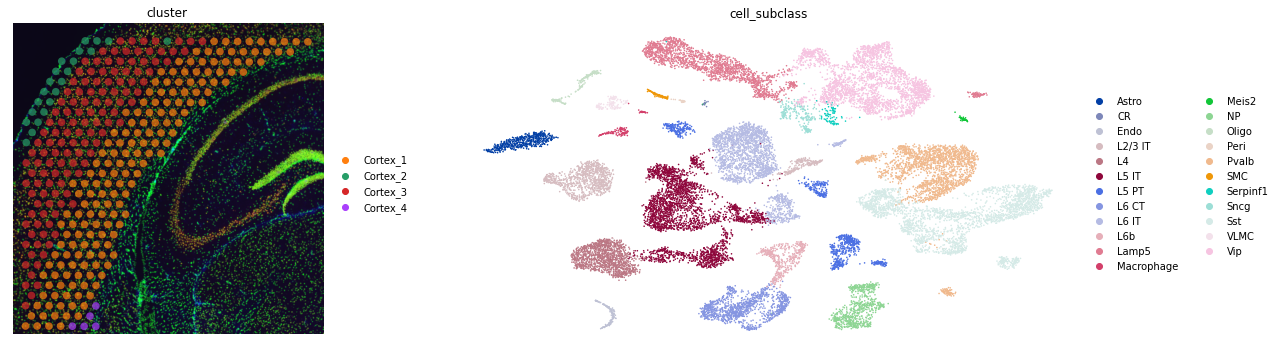

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

## Nuclei segmentation and segmentation features
As mentioned before, we are interested in segmenting single nuclei under each spot in the Visium dataset. Squidpy makes it possible with two lines of Python code:

- `squidpy.im.process` applies smoothing as a pre-processing step.
- `squidpy.im.segment` computes segmentation masks with watershed algorithm.

In [4]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

Let's visualize the results for an inset:

Text(0.5, 1.0, 'Nucleous segmentation')

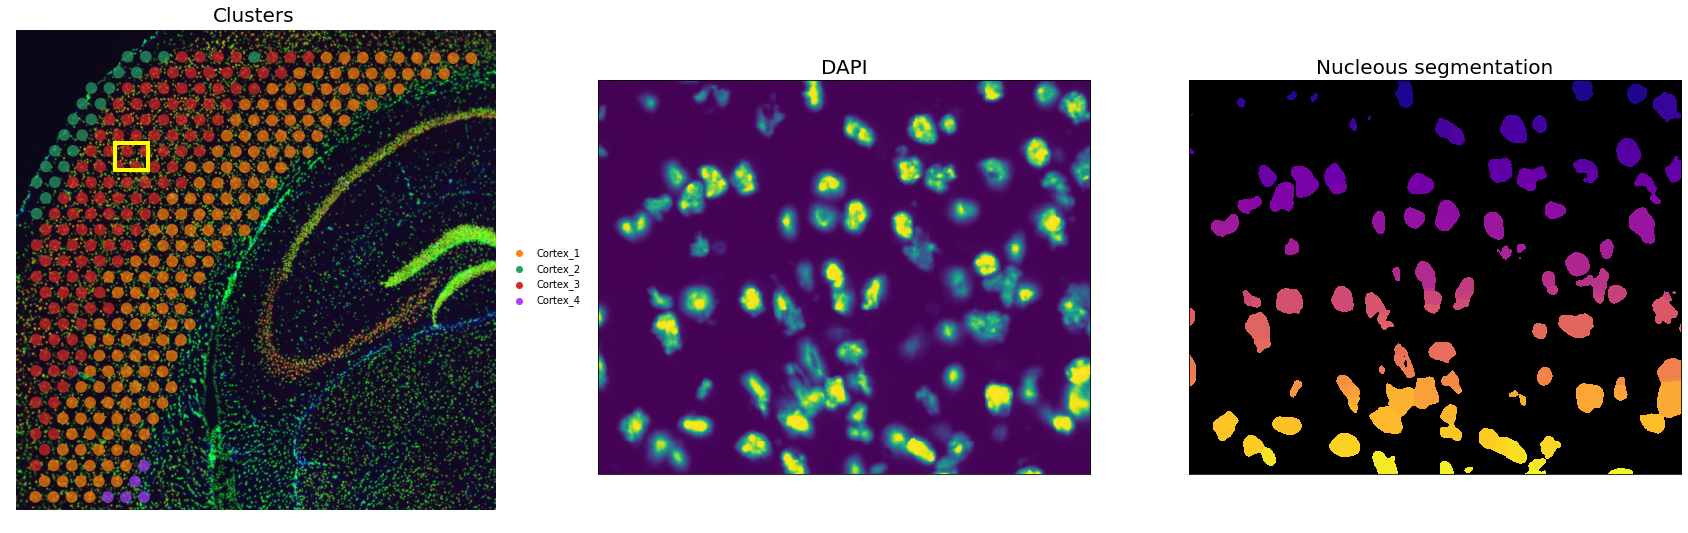

In [5]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20})

We can appreciate that despite some false positive, the nuclei segmentation worked well.

We then need to extract some image features useful for the deconvolution task downstream. Specifically, we will need:

- the number of unique segmentation objects (i.e. nuclei) under each spot.
- the coordinates of the centroids of the segmentation object.

It will become clear later how we will be using them.

In [6]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

100%|████████████████████████████████████████████████████████████████████████| 324/324 [01:21<00:00,  3.97/s]


We can visualize the total number of objects under each spot with scanpy.

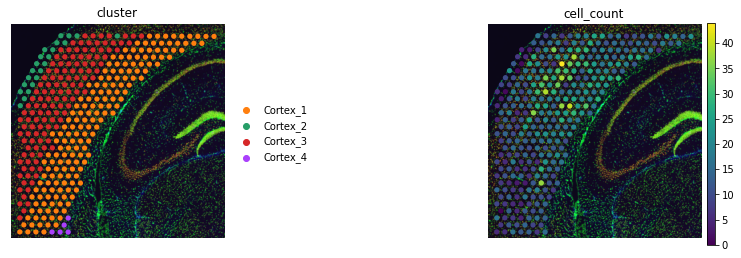

In [7]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

## Deconvolution and mapping
At this stage, we have all we need for the deconvolution task. 
First, we need to find a set of common genes the single cell and spatial datasets. 
We will use the intersection of the highly variable genes.

In [8]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

In [9]:
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
genes_sc = np.unique(markers_df.melt().value.values)
genes_st = adata_st.var_names.values
genes = list(set(genes_sc).intersection(set(genes_st)))
len(genes)

1281

In [10]:
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Now we are ready to instantiate the model object and its hyper parameters. Note that we are loading `torch` and training the model on the GPU. However, it's also possible to train it on the CPU, it will just be slower.

In [12]:
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="constrained",
    target_count=adata_st.obs.cell_count.sum(),
    density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and customized density_prior in constrained mode...


Score: 0.613, KL reg: 0.125, Count reg: 5749.440, Lambda f reg: 4468.216
Score: 0.698, KL reg: 0.012, Count reg: 5.031, Lambda f reg: 725.335
Score: 0.700, KL reg: 0.012, Count reg: 1.134, Lambda f reg: 246.555
Score: 0.701, KL reg: 0.012, Count reg: 0.791, Lambda f reg: 167.926
Score: 0.701, KL reg: 0.012, Count reg: 0.596, Lambda f reg: 141.399
Score: 0.701, KL reg: 0.012, Count reg: 0.298, Lambda f reg: 123.897
Score: 0.701, KL reg: 0.012, Count reg: 0.567, Lambda f reg: 108.323
Score: 0.701, KL reg: 0.012, Count reg: 0.855, Lambda f reg: 98.514
Score: 0.701, KL reg: 0.012, Count reg: 0.453, Lambda f reg: 92.554
Score: 0.701, KL reg: 0.012, Count reg: 1.135, Lambda f reg: 83.825


INFO:root:Saving results..


As a first result, we can take the average of the mapped cells and computes proportions from it. The following functions computes the proportions from the Tangram object result, and store them in the spatial AnnData object.

We can appreciate how average results already give a sense of the success of the deconvolution step. Cortical layers are indeed at higher proportions in the correct regions in the tissue.

Of course some layers seems to be better resolved then others. A more refined gene selection step could be of help in this case.

In [13]:
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


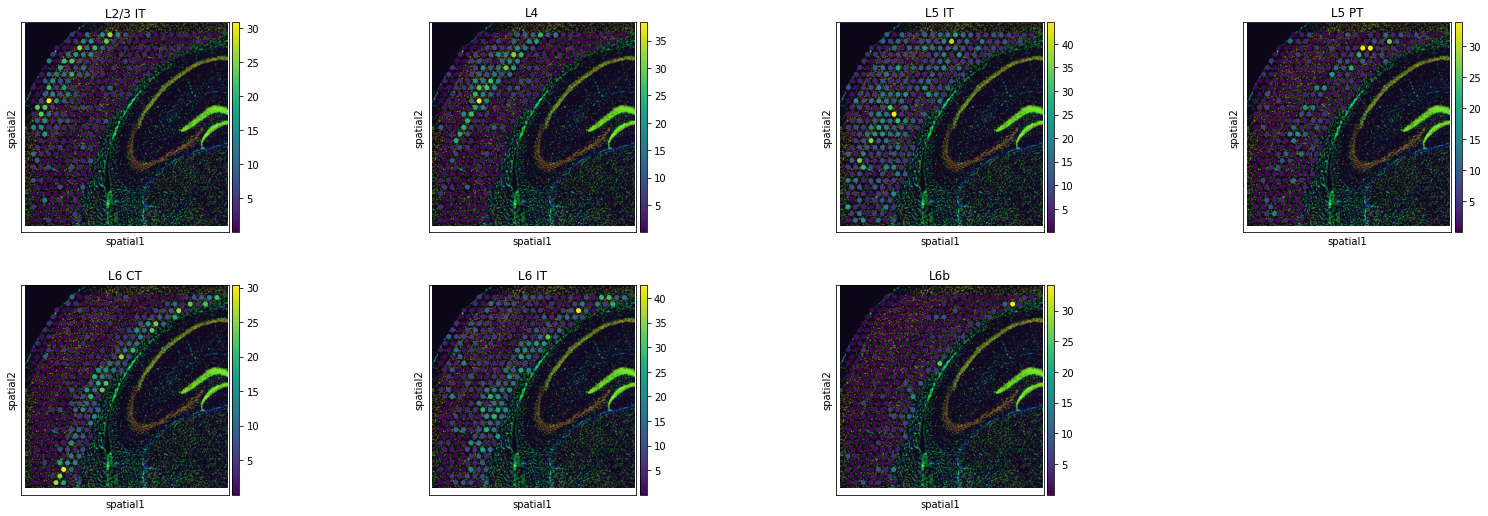

In [14]:
adata_st.obs = pd.concat([adata_st.obs, adata_st.obsm["tangram_ct_pred"]], axis=1)

sc.pl.spatial(
    adata_st,
    color=["L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"],
)

And here comes the key part, where we will use the results of the previous deconvolution steps. Previously, we computed the absolute numbers of unique segmentation objects under each spot, together with their centroids. Let's extract them in the right format useful for Tangram.

In the resulting dataframe, each row represents a single segmentation object (therefore a single nuclei). We also have the image coordinates as well as the unique centroid ID, which is a string that contains both the spot ID and a numerical index.

Tangram provide a convenient function to export the mapping between spot ID and segmentation ID to `adata.uns`.

In [15]:
tg.create_segment_cell_df(adata_st)

INFO:root:cell segmentation dataframe is saved in `uns` `tangram_cell_segmentation` of the spatial AnnData.
INFO:root:spot centroids is saved in `obsm` `tangram_spot_centroids` of the spatial AnnData.


In [16]:
adata_st.uns["tangram_cell_segmentation"].head()

spot_idx            y           x             centroids
0  AAATGGCATGTCTTGT-1  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0
1  AAATGGCATGTCTTGT-1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1
2  AAATGGCATGTCTTGT-1  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2
3  AAATGGCATGTCTTGT-1  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3
4  AAATGGCATGTCTTGT-1  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4

We can then use `tangram.count_cell_annotation()` to map cell types as result of the deconvolution step to putative segmentation ID.

In [17]:
tg.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)

INFO:root:spatial cell count dataframe is saved in `obsm` `tangram_ct_count` of the spatial AnnData.


In [18]:
adata_st.obsm["tangram_ct_count"].head()

x     y  cell_n  \
AAATGGCATGTCTTGT-1   641  5393      13   
AACAACTGGTAGTTGC-1  4208  1672      16   
AACAGGAAATCGAATA-1  1117  5117      28   
AACCCAGAGACGGAGA-1  1101  1274       5   
AACCGTTGTGTTTGCT-1   399  4708       7   

                                                            centroids  Pvalb  \
AAATGGCATGTCTTGT-1  [AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...      1   
AACAACTGGTAGTTGC-1  [AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...      0   
AACAGGAAATCGAATA-1  [AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...      1   
AACCCAGAGACGGAGA-1  [AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...      0   
AACCGTTGTGTTTGCT-1  [AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...      2   

                    L4  Vip  L2/3 IT  Lamp5  NP  ...  L5 PT  Astro  L6b  Endo  \
AAATGGCATGTCTTGT-1   0    0        0      0   0  ...      2      1    0     0   
AACAACTGGTAGTTGC-1   0    3        0      1   0  ...      1      0    0     0   
AACAGGAAATCGAATA-1   0    4        1      0   1  ...      0      1    0     0   
AACCCAGAGACGGAGA-1   1    0        0      2   0  ...      0      1    0     0   
AACCGTTGTGTTTGCT-1   1    0        0      0   0  ...      1      0    0     1   

                    Peri  Meis2  Macrophage  CR  VLMC  SMC  
AAATGGCATGTCTTGT-1     0      0           1   0     0    0  
AACAACTGGTAGTTGC-1     0      0           1   0     0    0  
AACAGGAAATCGAATA-1     0      0           1   0     0    0  
AACCCAGAGACGGAGA-1     0      0           0   0     0    0  
AACCGTTGTGTTTGCT-1     0      0           0   0     0    0  

[5 rows x 27 columns]

And then finally export the results in a new `AnnData` object.

In [19]:
adata_segment = tg.deconvolve_cell_annotations(adata_st)

In [20]:
adata_segment.obs.head()

y           x             centroids cluster
0  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0   Pvalb
1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1     Sst
2  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2   L5 IT
3  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3   L5 IT
4  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4   L6 CT

Note that the AnnData object does not contain counts, but only cell type annotations, as results of the Tangram mapping. 
Nevertheless, it's convenient to create such AnnData object for visualization purposes.

Below you can appreciate how each dot is now not a Visium spot anymore, but a single unique segmentation object, with the mapped cell type.

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

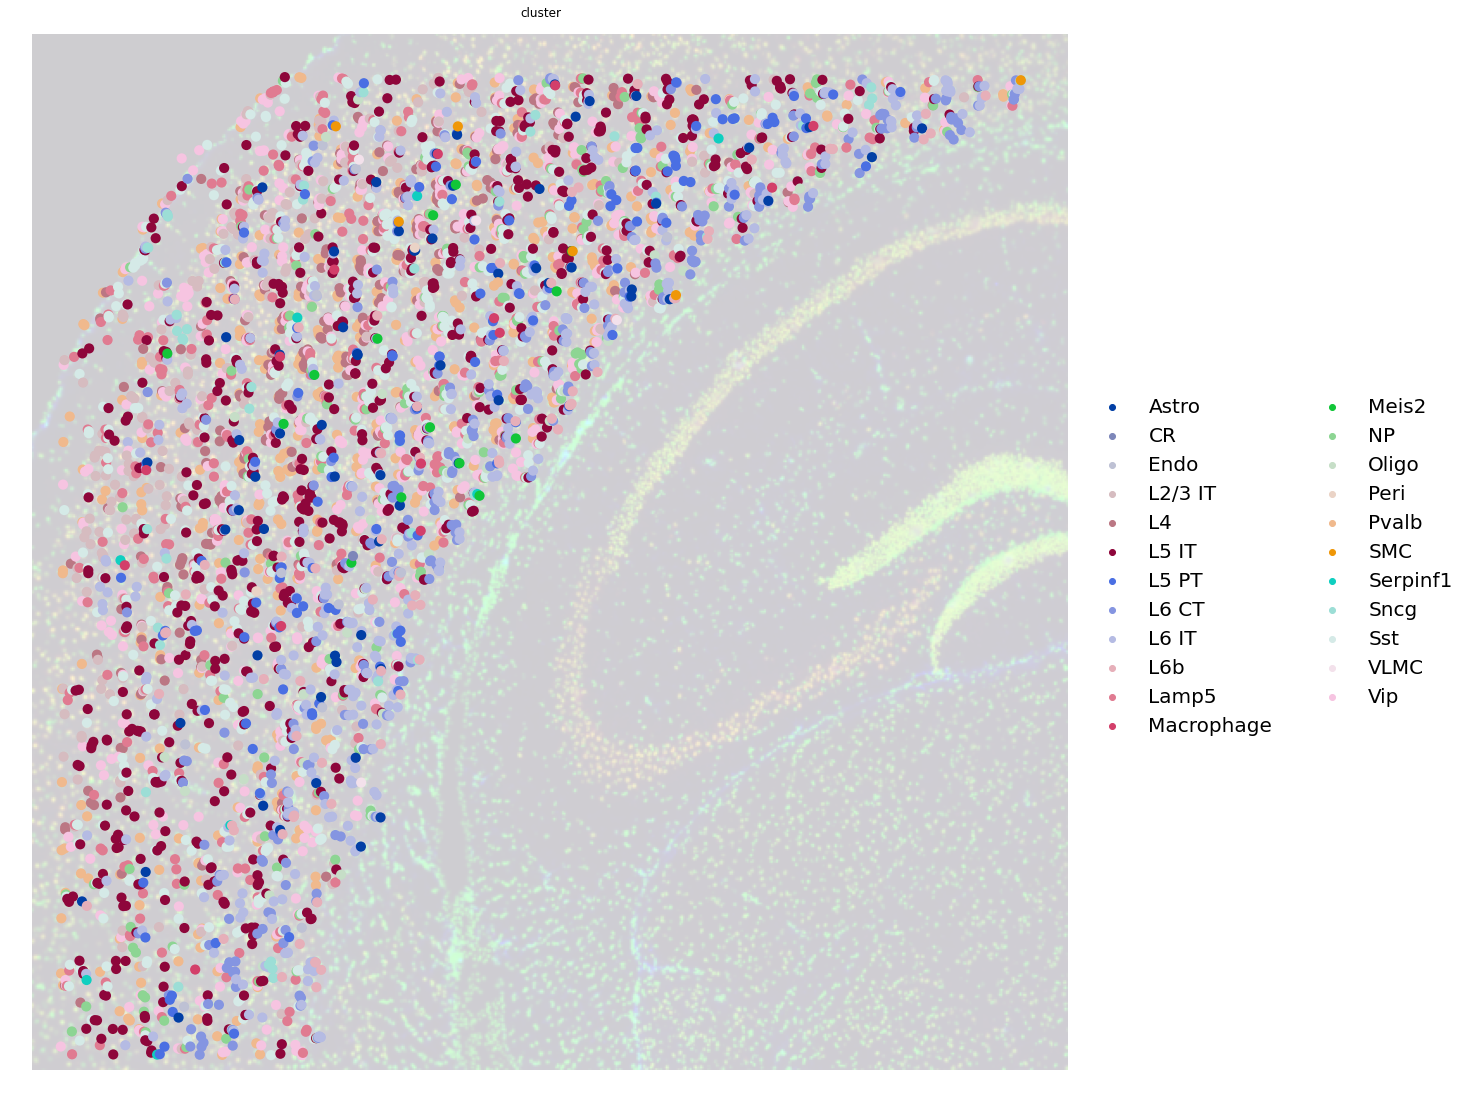

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_segment,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)